In [65]:
import xarray as xr
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Conv3D, Flatten,MaxPooling3D,AveragePooling3D, concatenate,Input ,SpatialDropout3D,Dropout
import keras
from math import e
from sklearn.model_selection import train_test_split
from keras.models import Model
from sklearn.preprocessing import StandardScaler
from joblib import dump, load
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform
from sklearn.model_selection import KFold

In [66]:
inputData = xr.open_dataset('../../Feb2021/Final_Models/Teleconnections/CNN_input.nc')

In [67]:
t2mTsAll=inputData.t2mTsAll
wsTsAll=inputData.wsTsAll
rhTsAll=inputData.rhTsAll
invTsAll=inputData.invTsAll
wTsAll=inputData.wTsAll
ushearTsAll=inputData.ushearTsAll
AO5DAll=inputData.AO5DAll
EU5DAll=inputData.EU5DAll
SST30DAll=inputData.SST30DAll

125
1086
745
382
80


(array([0.06461952, 0.56141439, 0.38513234, 0.19747725, 0.04135649]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. ]),
 <BarContainer object of 5 artists>)

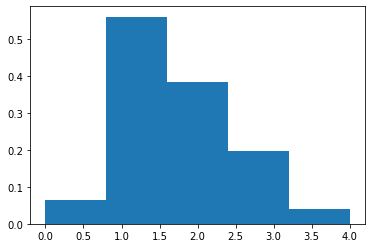

In [68]:
fogData = xr.open_dataset('../../../Data/FogData/CombinedFogData_25Stations.nc')
#plt.figure(figsize=[16,8])
StackFog=fogData.fogdata.stack(a=('years','months','days'))
StackFog
dd =[];
for i in range(StackFog.years.values.shape[0]):
    dd=dd+[str(StackFog.years[i].values)+'-'+str(StackFog.months[i].values)+"-"+str(StackFog.days[i].values)]
fg = xr.Dataset({'fogdata': (('time','stations'), StackFog.values.T)}, coords={'time': pd.to_datetime(dd),'stations': fogData.stations})
yAll=fg.fogdata.sum(dim='stations').sel(time=slice('1980-1-1','2018-12-31'))
yAll=yAll
yAll[(yAll>0)&(yAll<=6)]=1
yAll[(yAll>5)&(yAll<=12)]=2
yAll[(yAll>12)&(yAll<=18)]=3
yAll[(yAll>18)]=4
print(yAll[yAll==0].shape[0])
print(yAll[yAll==1].shape[0])
print(yAll[yAll==2].shape[0])
print(yAll[yAll==3].shape[0])
print(yAll[yAll==4].shape[0])
plt.hist(yAll, bins=5, density=True)

In [69]:
t2m_train,t2m_test,ws_train,ws_test,rh_train,rh_test,inv_train,inv_test, w_train, w_test,ushear_train, ushear_test,AO5D_train,AO5D_test,EU5D_train,EU5D_test,SST30D_train,SST30D_test,y_train,y_test= train_test_split( t2mTsAll,wsTsAll,rhTsAll,invTsAll, wTsAll,ushearTsAll,AO5DAll,EU5DAll,SST30DAll,yAll,test_size=0.20, random_state=0)

In [70]:
t2mtrain=t2m_train.values
t2mtrain=t2mtrain[:,:,:,None]
t2mtrain.shape


wstrain=ws_train.values
wstrain=wstrain[:,:,:,None]
wstrain.shape

rhtrain=rh_train.values
rhtrain=rhtrain[:,:,:,None]
rhtrain.shape


invtrain=inv_train.values
invtrain=invtrain[:,:,:,None]
invtrain.shape

wtrain=w_train.values
wtrain=wtrain[:,:,:,None]
wtrain.shape

usheartrain=ushear_train.values
usheartrain=usheartrain[:,:,:,None]
usheartrain.shape

AO5Dtrain=AO5D_train.values
AO5Dtrain=AO5Dtrain[:,:,:,None]
AO5Dtrain.shape

EU5Dtrain=EU5D_train.values
EU5Dtrain=EU5Dtrain[:,:,:,None]
EU5Dtrain.shape

SST30Dtrain=SST30D_train.values
SST30Dtrain=SST30Dtrain[:,:,:,None]
SST30Dtrain.shape

(1934, 18, 26, 1)

In [71]:
t2mtest=t2m_test.values
t2mtest=t2mtest[:,:,:,None]
t2mtest.shape


wstest=ws_test.values
wstest=wstest[:,:,:,None]
wstest.shape

rhtest=rh_test.values
rhtest=rhtest[:,:,:,None]
rhtest.shape


invtest=inv_test.values
invtest=invtest[:,:,:,None]
invtest.shape

wtest=w_test.values
wtest=wtest[:,:,:,None]
wtest.shape

usheartest=ushear_test.values
usheartest=usheartest[:,:,:,None]
usheartest.shape

AO5Dtest=AO5D_test.values
AO5Dtest=AO5Dtest[:,:,:,None]
AO5Dtest.shape

EU5Dtest=EU5D_test.values
EU5Dtest=EU5Dtest[:,:,:,None]
EU5Dtest.shape

SST30Dtest=SST30D_test.values
SST30Dtest=SST30Dtest[:,:,:,None]
SST30Dtest.shape

(484, 18, 26, 1)

In [72]:
ytrain=y_train.values
ytrain=ytrain[:,None]
ytrain.shape
ytest=y_test.values
ytest=ytest[:,None]
ytest.shape

(484, 1)

In [73]:
#one hot encoding of labels
from keras.utils import np_utils
y_train=np_utils.to_categorical(y_train,5)
y_test=np_utils.to_categorical(y_test,5)

print(y_train[1]) # output [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.] which means label is 6 which represents a frog



[0. 1. 0. 0. 0.]


(6, 1934, 18, 26, 1)
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_37 (Conv3D)           (None, 6, 18, 26, 16)     448       
_________________________________________________________________
average_pooling3d_24 (Averag (None, 3, 9, 13, 16)      0         
_________________________________________________________________
conv3d_38 (Conv3D)           (None, 3, 9, 13, 32)      13856     
_________________________________________________________________
average_pooling3d_25 (Averag (None, 2, 5, 7, 32)       0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 2, 5, 7, 32)       0         
_________________________________________________________________
conv3d_39 (Conv3D)           (None, 2, 5, 7, 64)       55360     
_________________________________________________________________
average_pooling3d_26 (Averag (No

61/61 [==============================] - 1s 17ms/step - loss: 0.1319 - acc: 0.9450
Epoch 62/100
61/61 [==============================] - 1s 17ms/step - loss: 0.1398 - acc: 0.9498
Epoch 63/100
61/61 [==============================] - 1s 17ms/step - loss: 0.1374 - acc: 0.9459
Epoch 64/100
61/61 [==============================] - 1s 17ms/step - loss: 0.1222 - acc: 0.9589
Epoch 65/100
61/61 [==============================] - 1s 17ms/step - loss: 0.1427 - acc: 0.9417
Epoch 66/100
61/61 [==============================] - 1s 17ms/step - loss: 0.1306 - acc: 0.9566
Epoch 67/100
61/61 [==============================] - 1s 17ms/step - loss: 0.1028 - acc: 0.9570
Epoch 68/100
61/61 [==============================] - 1s 17ms/step - loss: 0.0905 - acc: 0.9704
Epoch 69/100
61/61 [==============================] - 1s 18ms/step - loss: 0.0879 - acc: 0.9713
Epoch 70/100
61/61 [==============================] - 1s 18ms/step - loss: 0.1301 - acc: 0.9469
Epoch 71/100
61/61 [==============================] -

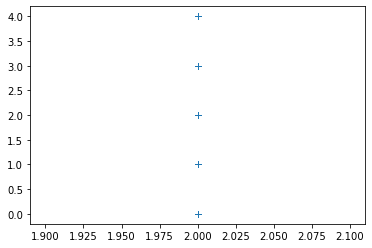

In [84]:
X_test=np.array([t2mtest,rhtest,wstest,invtest,wtest,usheartest])
#X_test=np.array([rhtest,wstest,invtest,wtest,usheartest,aotest,eutest])
X_test.shape

X_train=np.array([t2mtrain,rhtrain,wstrain,invtrain,wtrain,usheartrain])
#X_train=np.array([rhtrain,wstrain,invtrain,wtrain,usheartrain,aotrain,eutrain])
print(X_train.shape)

X_train_reshape = np.einsum('lkija->klija',X_train)
X_train_reshape.shape

X_test_reshape = np.einsum('lkija->klija',X_test)
X_test_reshape.shape


model = Sequential()
model.add(Conv3D(16, kernel_size=3, activation='relu',padding='same',
                     input_shape=(X_train_reshape.shape[1],X_train_reshape.shape[2],X_train_reshape.shape[3],1)),)
model.add(AveragePooling3D(pool_size=2,padding='same'))
model.add(Conv3D(32, kernel_size=3, activation='relu',padding='same'))
model.add(AveragePooling3D(pool_size=2,padding='same'))
model.add(Dropout(0.2))
model.add(Conv3D(64, kernel_size=3, activation='relu',padding='same'))
model.add(AveragePooling3D(pool_size=2,padding='same'))
model.add(Dropout(0.2))
model.add(Conv3D(128, kernel_size=3, activation='relu',padding='same'))
model.add(AveragePooling3D(pool_size=2,padding='same'))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(units=5, activation = 'softmax'))

adam = keras.optimizers.Adam(lr=0.01)
model.compile(optimizer='adam', loss='categorical_crossentropy',  metrics='acc')
model.summary()
history = model.fit(X_train_reshape, y_train, epochs=100)
#yy_test = model.predict(X_test_reshape)
yy_test=np.argmax ( model.predict ( X_test_reshape/255 ), axis=-1 )
print(yy_test)
y_test2=np.argmax (  y_test/255 , axis=-1 )
print(y_test2)    
plt.plot(yy_test,y_test2,'+')
scores = model.evaluate(X_test_reshape, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


(6, 1934, 18, 26, 1)
Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_50 (Conv3D)           (None, 6, 18, 26, 16)     448       
_________________________________________________________________
average_pooling3d_37 (Averag (None, 3, 9, 13, 16)      0         
_________________________________________________________________
conv3d_51 (Conv3D)           (None, 3, 9, 13, 32)      13856     
_________________________________________________________________
average_pooling3d_38 (Averag (None, 2, 5, 7, 32)       0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 2, 5, 7, 32)       0         
_________________________________________________________________
conv3d_52 (Conv3D)           (None, 2, 5, 7, 64)       55360     
_________________________________________________________________
average_pooling3d_39 (Averag (No

Epoch 43/100
61/61 [==============================] - 1s 22ms/step - loss: 0.3278 - acc: 0.8658 - val_loss: 1.1394 - val_acc: 0.6364
Epoch 44/100
61/61 [==============================] - 1s 22ms/step - loss: 0.2369 - acc: 0.9081 - val_loss: 1.2115 - val_acc: 0.6446
Epoch 45/100
61/61 [==============================] - 1s 22ms/step - loss: 0.2548 - acc: 0.9036 - val_loss: 1.1980 - val_acc: 0.6384
Epoch 46/100
61/61 [==============================] - 1s 23ms/step - loss: 0.2579 - acc: 0.8951 - val_loss: 1.1894 - val_acc: 0.6364
Epoch 47/100
61/61 [==============================] - 1s 22ms/step - loss: 0.2328 - acc: 0.9181 - val_loss: 1.1748 - val_acc: 0.6488
Epoch 48/100
61/61 [==============================] - 1s 22ms/step - loss: 0.2505 - acc: 0.8918 - val_loss: 1.1899 - val_acc: 0.6591
Epoch 49/100
61/61 [==============================] - 1s 23ms/step - loss: 0.2228 - acc: 0.9123 - val_loss: 1.4134 - val_acc: 0.6694
Epoch 50/100
61/61 [==============================] - 1s 25ms/step - 

acc: 66.53%


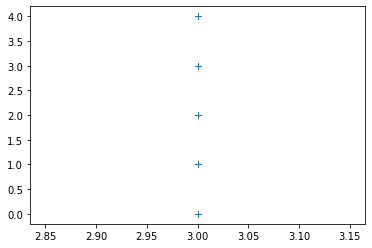

In [90]:
X_test=np.array([t2mtest,rhtest,wstest,invtest,wtest,usheartest])
#X_test=np.array([rhtest,wstest,invtest,wtest,usheartest,aotest,eutest])
X_test.shape

X_train=np.array([t2mtrain,rhtrain,wstrain,invtrain,wtrain,usheartrain])
#X_train=np.array([rhtrain,wstrain,invtrain,wtrain,usheartrain,aotrain,eutrain])
print(X_train.shape)

X_train_reshape = np.einsum('lkija->klija',X_train)
X_train_reshape.shape

X_test_reshape = np.einsum('lkija->klija',X_test)
X_test_reshape.shape


model = Sequential()
model.add(Conv3D(16, kernel_size=3, activation='relu',padding='same',
                     input_shape=(X_train_reshape.shape[1],X_train_reshape.shape[2],X_train_reshape.shape[3],1)),)
model.add(AveragePooling3D(pool_size=2,padding='same'))
model.add(Conv3D(32, kernel_size=3, activation='relu',padding='same'))
model.add(AveragePooling3D(pool_size=2,padding='same'))
model.add(Dropout(0.2))
model.add(Conv3D(64, kernel_size=3, activation='relu',padding='same'))
model.add(AveragePooling3D(pool_size=2,padding='same'))
model.add(Dropout(0.2))
model.add(Conv3D(128, kernel_size=3, activation='relu',padding='same'))
model.add(AveragePooling3D(pool_size=2,padding='same'))
model.add(Dropout(0.2))
model.add(Conv3D(256, kernel_size=3, activation='relu',padding='same'))
model.add(AveragePooling3D(pool_size=2,padding='same'))
model.add(Dropout(0.2))


model.add(Flatten())

model.add(Dense(32, activation='relu'))
model.add(Dense(units=5, activation = 'softmax'))

adam = keras.optimizers.Adam(lr=0.01)
model.compile(optimizer='adam', loss='categorical_crossentropy',  metrics='acc')
model.summary()
history = model.fit(X_train_reshape, y_train, validation_data=(X_test_reshape, y_test),epochs=100)
#yy_test = model.predict(X_test_reshape)
yy_test=np.argmax ( model.predict ( X_test_reshape/255 ), axis=-1 )
print(yy_test)
y_test2=np.argmax (  y_test/255 , axis=-1 )
print(y_test2)    
plt.plot(yy_test,y_test2,'+')
scores = model.evaluate(X_test_reshape, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


(9, 1934, 18, 26, 1)
Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_76 (Conv3D)           (None, 9, 18, 26, 16)     448       
_________________________________________________________________
average_pooling3d_63 (Averag (None, 5, 9, 13, 16)      0         
_________________________________________________________________
conv3d_77 (Conv3D)           (None, 5, 9, 13, 32)      13856     
_________________________________________________________________
average_pooling3d_64 (Averag (None, 3, 5, 7, 32)       0         
_________________________________________________________________
dropout_39 (Dropout)         (None, 3, 5, 7, 32)       0         
_________________________________________________________________
conv3d_78 (Conv3D)           (None, 3, 5, 7, 64)       55360     
_________________________________________________________________
average_pooling3d_65 (Averag (No

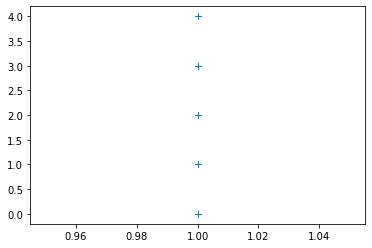

In [99]:
X_test=np.array([t2mtest,rhtest,wstest,invtest,wtest,usheartest,AO5Dtest,EU5Dtest,SST30Dtest])
#X_test=np.array([rhtest,wstest,invtest,wtest,usheartest,aotest,eutest])
X_test.shape

X_train=np.array([t2mtrain,rhtrain,wstrain,invtrain,wtrain,usheartrain,AO5Dtrain,EU5Dtrain,SST30Dtrain])
#X_train=np.array([rhtrain,wstrain,invtrain,wtrain,usheartrain,aotrain,eutrain])
print(X_train.shape)

X_train_reshape = np.einsum('lkija->klija',X_train)
X_train_reshape.shape

X_test_reshape = np.einsum('lkija->klija',X_test)
X_test_reshape.shape


model = Sequential()
model.add(Conv3D(16, kernel_size=3, activation='relu',padding='same',
                     input_shape=(X_train_reshape.shape[1],X_train_reshape.shape[2],X_train_reshape.shape[3],1)),)
model.add(AveragePooling3D(pool_size=2,padding='same'))
model.add(Conv3D(32, kernel_size=3, activation='relu',padding='same'))
model.add(AveragePooling3D(pool_size=2,padding='same'))
model.add(Dropout(0.2))
model.add(Conv3D(64, kernel_size=3, activation='relu',padding='same'))
model.add(AveragePooling3D(pool_size=2,padding='same'))
model.add(Dropout(0.2))
model.add(Conv3D(128, kernel_size=3, activation='relu',padding='same'))
model.add(AveragePooling3D(pool_size=2,padding='same'))
model.add(Dropout(0.2))
model.add(Conv3D(256, kernel_size=3, activation='relu',padding='same'))
model.add(AveragePooling3D(pool_size=2,padding='same'))
model.add(Dropout(0.2))


model.add(Flatten())

model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(units=5, activation = 'softmax'))

adam = keras.optimizers.RMSprop(lr=0.1)#(lr=0.01)
model.compile(optimizer='adam', loss='categorical_crossentropy',  metrics='acc')
model.summary()
history = model.fit(X_train_reshape, y_train, validation_data=(X_test_reshape, y_test),epochs=20)
#yy_test = model.predict(X_test_reshape)
yy_test=np.argmax ( model.predict ( X_test_reshape/255 ), axis=-1 )
print(yy_test)
y_test2=np.argmax (  y_test/255 , axis=-1 )
print(y_test2)    
plt.plot(yy_test,y_test2,'+')
scores = model.evaluate(X_test_reshape, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


(3, 1934, 18, 26, 1)
Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_70 (Conv3D)           (None, 3, 18, 26, 16)     448       
_________________________________________________________________
average_pooling3d_57 (Averag (None, 2, 9, 13, 16)      0         
_________________________________________________________________
flatten_35 (Flatten)         (None, 3744)              0         
_________________________________________________________________
dense_69 (Dense)             (None, 5)                 18725     
Total params: 19,173
Trainable params: 19,173
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
61/61 [==============================] - 1s 10ms/step - loss: 1.3757 - acc: 0.4022 - val_loss: 1.3126 - val_acc: 0.4607
Epoch 2/10
61/61 [==============================] - 0s 8ms/step - loss: 1.3154 - acc: 0.4371 - 

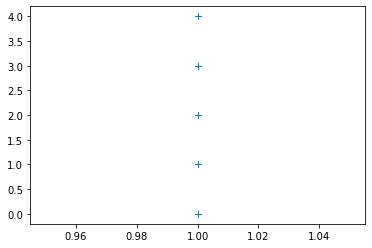

In [97]:
X_test=np.array([AO5Dtest,EU5Dtest,SST30Dtest])
#X_test=np.array([rhtest,wstest,invtest,wtest,usheartest,aotest,eutest])
X_test.shape

X_train=np.array([AO5Dtrain,EU5Dtrain,SST30Dtrain])
#X_train=np.array([rhtrain,wstrain,invtrain,wtrain,usheartrain,aotrain,eutrain])
print(X_train.shape)

X_train_reshape = np.einsum('lkija->klija',X_train)
X_train_reshape.shape

X_test_reshape = np.einsum('lkija->klija',X_test)
X_test_reshape.shape


model = Sequential()
model.add(Conv3D(16, kernel_size=3, activation='relu',padding='same',
                     input_shape=(X_train_reshape.shape[1],X_train_reshape.shape[2],X_train_reshape.shape[3],1)),)
model.add(AveragePooling3D(pool_size=2,padding='same'))



model.add(Flatten())

#model.add(Dense(32, activation='relu'))
model.add(Dense(units=5, activation = 'sigmoid'))

adam = keras.optimizers.RMSprop(lr=0.1)#(lr=0.01)
model.compile(optimizer='adam', loss='categorical_crossentropy',  metrics='acc')
model.summary()
history = model.fit(X_train_reshape, y_train, validation_data=(X_test_reshape, y_test),epochs=10)
#yy_test = model.predict(X_test_reshape)
yy_test=np.argmax ( model.predict ( X_test_reshape/255 ), axis=-1 )
print(yy_test)
y_test2=np.argmax (  y_test/255 , axis=-1 )
print(y_test2)    
plt.plot(yy_test,y_test2,'+')
scores = model.evaluate(X_test_reshape, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
